In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

## É possível predizer quantas estrelas foram dadas em um review de uma empresa com base no texto de comentário ?

In [2]:
json_size = 150000
for _json in pd.read_json('../yelp_dataset/yelp_academic_dataset_review.json', chunksize=json_size, lines=True):
    reviews = _json
    break

In [3]:
business = pd.read_json('../yelp_dataset/yelp_academic_dataset_business.json', lines=True)
columns_to_stay = ['business_id','name','stars']
business = business[columns_to_stay]
business.head()

,business_id,name,stars
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,4.0
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,4.5
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,4.0
3,bFzdJJ3wp3PZssNEsyU23g,Geico Insurance,1.5
4,8USyCYqpScwiNEb58Bt6CA,Action Engine,2.0


In [4]:
dataset = reviews.merge(business,how='left', on='business_id')
dataset.rename({'stars_x':'review stars', 'stars_y':'business stars'},inplace=True, axis='columns')
dataset_columns_to_stay = ['name','business_id','text','review stars','business stars','cool',  'useful', 'funny']
dataset = dataset[dataset_columns_to_stay]
dataset.to_json('../yelp_dataset/dataset.json')
dataset.head()

,name,business_id,text,review stars,business stars,cool,useful,funny
0,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,The pizza was okay. Not the best I've had. I p...,2,4.0,0,0,0
1,Leticia's Mexican Cocina,pomGBqfbxcqPv14c3XH-ZQ,I love this place! My fiance And I go here atl...,5,4.0,0,0,0
2,H&H BBQ Plus 2,jtQARsP6P-LbkyjbO1qNGg,Terrible. Dry corn bread. Rib tips were all fa...,1,3.5,1,3,1
3,Pin Kaow Thai Restaurant,elqbBhBfElMNSrjFqW3now,Back in 2005-2007 this place was my FAVORITE t...,2,4.0,0,2,0
4,Braddah's Island Style,Ums3gaP2qM3W1XcA5r6SsQ,Delicious healthy food. The steak is amazing. ...,5,4.0,0,0,0


### Verificando correlação das features com a feature target
- Observa-se que a única coluna que tem grande correlação é a business star, contudo ela é inviesada por ser a média de todas as reviews stars. 

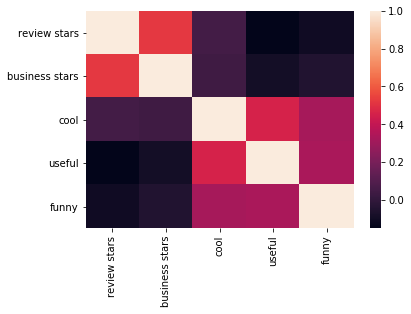

In [5]:
sns.heatmap(dataset.corr())

### Verificando integridade dos dados
- Verificar se existe alguma coluna nula
- Verificar o mínimo e máximo dos valores das features
- Dropar, se pertinente, textos incoerentes

In [22]:
dataset[dataset.isnull().any(axis=1)].shape

(0, 8)

In [25]:
dataset.text.str.len().min()

1

In [34]:
dataset.text.str.len().max()

5000

In [38]:
dataset[(dataset.text.str.len() < 4 )].count()

name              1
business_id       1
text              1
review stars      1
business stars    1
cool              1
useful            1
funny             1
dtype: int64

In [39]:
dataset.drop(dataset[(dataset.text.str.len() < 4 )].index,inplace=True)

In [31]:
dataset.max()

name                                               ​Century Library
business_id                                  zzwicjPC9g246MK2M1ZFBA
text              Über Frau Kähler hört man sehr viel gutes. Mit...
review stars                                                      5
business stars                                                    5
cool                                                             90
useful                                                          536
funny                                                           328
dtype: object

In [51]:
dataset.min()

name                                                      # 1 Nails
business_id                                  --6MefnULPED_I942VcFNA
text              !!! BIG WOW !!!\n\nMy wife and I held our wedd...
review stars                                                      1
business stars                                                    1
cool                                                              0
useful                                                            0
funny                                                             0
dtype: object

### Verificando distribuição da feature target

In [54]:
starts_total = dataset.groupby('review stars')['review stars'].count()

review stars
1    27150
2    12695
3    12809
4    28341
5    69004
Name: review stars, dtype: int64

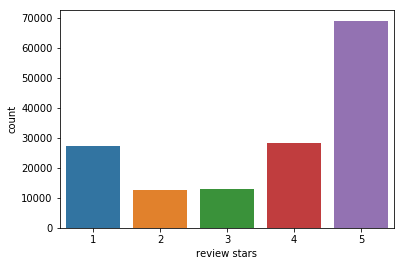

In [61]:
sns.countplot(x=dataset['review stars'], data=dataset)

### Criando WordCloud

In [16]:
all_text = " ".join(review for review in dataset.text)

In [17]:
wordcloud = WordCloud().generate(all_text)

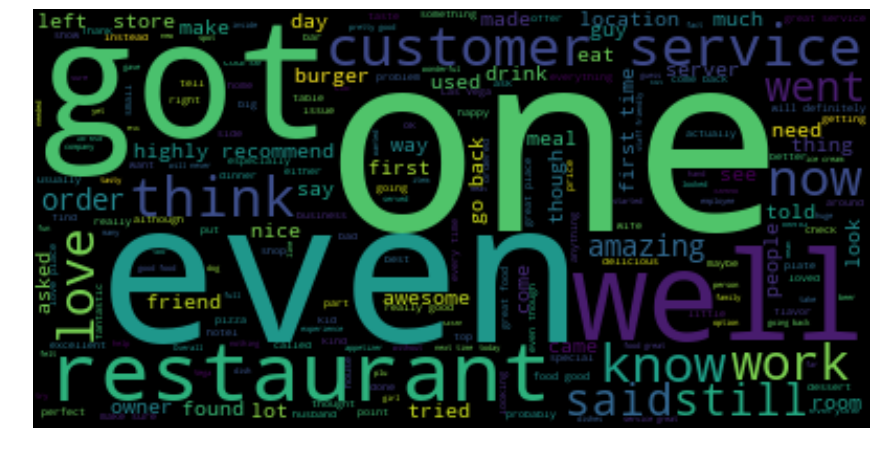

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [42]:
dataset['review stars'].shape

(149999,)

In [43]:
X = dataset['text'].tolist()
y = dataset['business stars'].tolist()


_pipe = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english',lowercase=True,analyzer='word',token_pattern=r'\w+')),
    ('linear', LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y)

_pipe.fit(X_train, y_train)
predict_linear = _pipe.predict(X_test)

In [45]:
print(mean_squared_error(y_test,predict_linear))

1.5144307522865639


In [48]:
_pipe_knr = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english',lowercase=True,analyzer='word',token_pattern=r'\w+')),
    ('KNR', KNeighborsRegressor(n_neighbors=5))
])
_pipe_knr.fit(X_train, y_train)
predict_knr = _pipe.predict(X_test)

In [49]:
print(mean_squared_error(y_test,predict_knr))

1.5144307522865639
